# Depth map computation

_Author: Louis Martinez_

This notebook presents the first estimate of the near-envelope using a Winner Takes All strategy 

In [ ]:
%load_ext autoreload
%autoreload 2

import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
import polars as pl

from utils import *
from depth_estimation import *

# needs to be changed according to where the data are located
root = "../../res/sparse"
model_root = os.path.join(root, "model")
images_root = os.path.join(root, "undistorted")

# Global config
cfg = get_global_params("../../res/params.txt")

### Load metadata

We load the metadata files generated using the `format_colmap_data.py` script. These files are .parquet files containing all the usefull metadata for every image, including extrinsic parameters and the sparse reconstruction outputted by colmap (only used during the development of the pipeline to have control points).

In [ ]:
images_df = pl.read_parquet(os.path.join(model_root, "images.parquet"))
images_df.sort(by="IMAGE_ID")

IMAGE_ID,QW,QX,QY,QZ,TX,TY,TZ,CAMERA_ID,NAME,"POINTS2D[]_as_(X,Y,POINT3D_ID)"
i64,f64,f64,f64,f64,f64,f64,f64,i64,str,list[list[f64]]
1,-0.488472,-0.280591,0.81914,-0.108042,-0.394513,1.29387,-3.04357,1,"""ldr/creepyattic_0003.jpg""","[[54.784, 12.975, -1.0], [86.0292, 85.59, -1.0], … [1646.48, 2252.16, -1.0]]"
2,0.563159,-0.060981,-0.609996,0.55411,-0.370288,-1.32416,-2.68216,1,"""ldr/creepyattic_0006.jpg""","[[112.492, 77.3008, -1.0], [100.939, 113.47, -1.0], … [749.852, 2210.63, -1.0]]"
3,-0.393841,-0.223818,0.889252,-0.063449,-0.555555,1.53751,-3.2407,1,"""ldr/creepyattic_0009.jpg""","[[108.863, 65.5852, -1.0], [108.863, 65.5852, -1.0], … [1329.39, 2112.68, -1.0]]"
4,-0.440466,0.0470181,0.695399,-0.565861,-0.504173,-1.31802,-2.96647,1,"""ldr/creepyattic_0012.jpg""","[[15.5087, 12.5388, -1.0], [90.8854, 40.4772, -1.0], … [1163.81, 660.992, -1.0]]"
5,-0.295292,-0.138807,0.944121,-0.046596,-0.369866,1.61101,-3.31681,1,"""ldr/creepyattic_0015.jpg""","[[48.8417, 24.7324, -1.0], [77.0122, 42.1555, -1.0], … [1814.96, 945.693, -1.0]]"
…,…,…,…,…,…,…,…,…,…,…
46,0.760215,-0.056664,-0.465825,0.449298,-0.305835,-1.74541,-2.98788,1,"""ldr/creepyattic_0138.jpg""","[[157.361, 95.6087, -1.0], [169.564, 98.282, -1.0], … [396.839, 1798.16, -1.0]]"
47,0.543056,0.349226,-0.762589,0.0398648,-0.40099,1.6398,-3.5683,1,"""ldr/creepyattic_0141.jpg""","[[103.731, 102.417, -1.0], [154.152, 62.4553, -1.0], … [1210.56, 1113.31, -1.0]]"
48,0.678829,-0.060785,-0.549105,0.483714,-0.69971,-1.70313,-3.11027,1,"""ldr/creepyattic_0144.jpg""","[[84.2955, 125.851, -1.0], [231.501, 16.2334, -1.0], … [1037.27, 2167.49, -1.0]]"


#### Visualize all images to manually select neighboring

As mentioned in the report, although it is possible to develop automatic methods, we stick we manual selection for the experiments since it's not time consuming. 

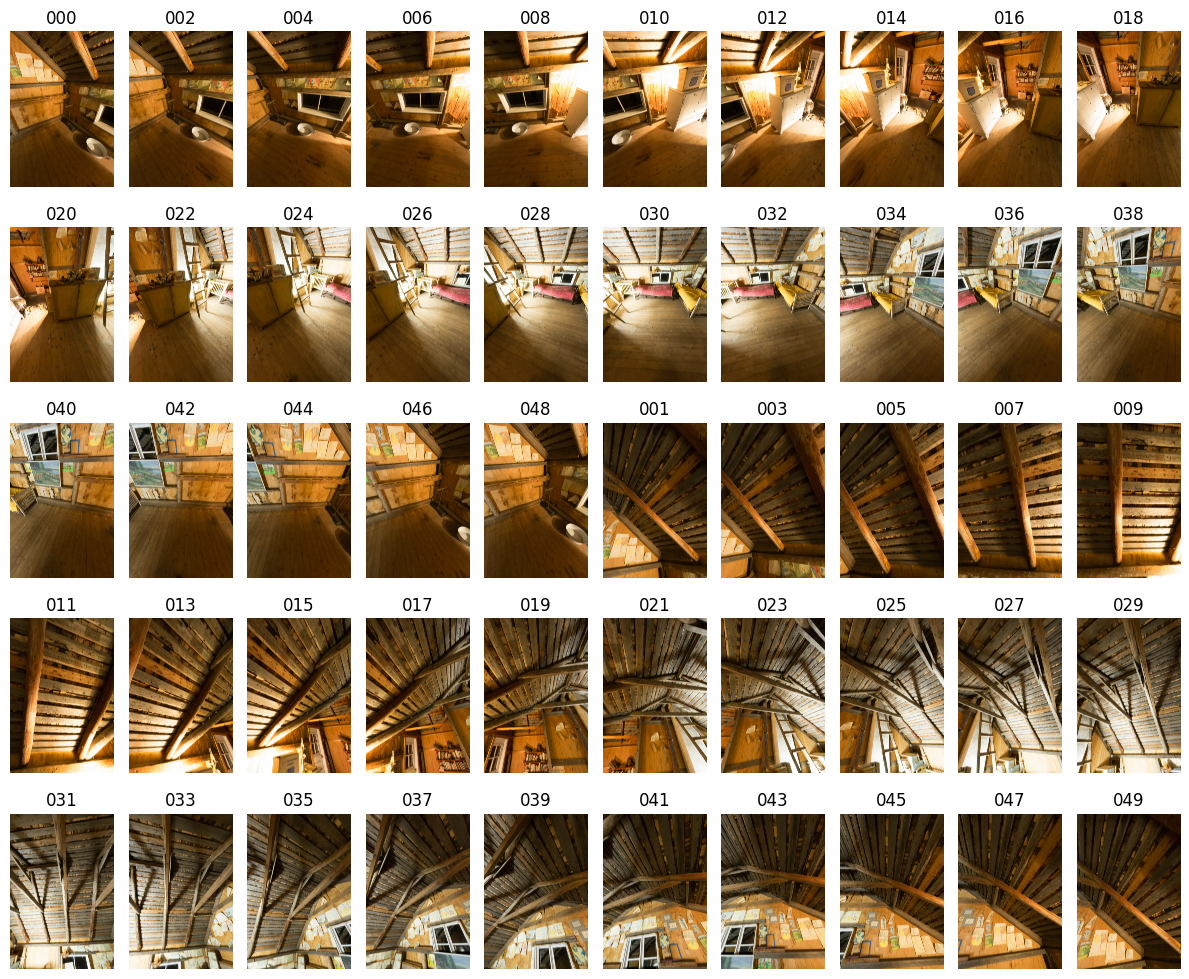

In [3]:
image_ids = images_df["IMAGE_ID"].to_numpy()
indices = range(len(image_ids))
even_indices = [i for i in indices if i % 2 == 0]
even_indices.sort()
odd_indices = [i for i in indices if i % 2 == 1]
odd_indices.sort()
sorted_indices = even_indices + odd_indices

fig, axes = plt.subplots(5, 10, figsize=(12, 10))
ax = axes.ravel()
for a, idx in zip(ax, sorted_indices):
    im_title = f"{idx:03d}"
    im = imread(os.path.join(images_root, f"{im_title}.jpg"))
    a.imshow(im)
    a.set_title(f"{im_title}")
    a.axis("off")

plt.tight_layout()

#### Define depth hypotheses and downscale factor to speed-up computations

In [4]:
downscale_factor = 16

dmin = cfg["minDepthForScene"] * cfg["colmapToMeters"]
dmax = cfg["maxDepthForScene"] * cfg["colmapToMeters"]
n_depths = 220
dhyp = compute_depth_hypothesis(n_depths, dmin, dmax)
dhyp_colmap = dhyp / cfg["colmapToMeters"]

#### Load camera intrinsic parameters

Since all the images were captured with the same camera, we take the parameters of the first image

In [5]:
K = get_K(os.path.join(images_root, "000.jpg.camera.txt")) / downscale_factor
fx, fy, cx, cy = get_K(os.path.join(images_root, "000.jpg.camera.txt"), as_matrix=False)

### Load anchor image and neighbor images

In [6]:
# ==> Load anchor image
anchor_idx = 0
anchor_image, anchor_image_full = load_image_by_index(root=images_root, 
                                   index=anchor_idx, 
                                   downscale_factor=downscale_factor,
                                   return_fullsize=True)
anchor_R, anchor_t = get_extrinsic_params(images_df, anchor_idx+1)

n_rows, n_cols = anchor_image.shape[:-1]

# ==> Manually defined neighbors
# boatshed like paper
# neigh_indices = np.array([42,44,46,48, # bottom-right
#                 32,34,36,38, # bottom-left
#                 41,43,45,47, # top-right
#                 33,35,37,39]) # top-left
# ladder indoor
# neigh_indices = np.array([30,32,34,36, # bottom-right
#                 20,22,24,26, # bottom-left
#                 31,33,35,37, # top-right
#                 23,25,27,29]) # top-left
# first indoor
neigh_indices = np.array([2, 4, 6, 8, # bottom-right
                42,44,46,48, # bottom-left
                1, 3, 5, 7, # top-right
                43,45,47,49]) # top-left

In [7]:
# Neighbor images (n_neighbors, row, col, channel)
neigh_images, neigh_images_full = load_neighbor_images(root=images_root, 
                                    indices=neigh_indices,
                                    downscale_factor=downscale_factor)

# Load extrinsic params of all neighboring images -> R: (n_neighbors, 3, 3), t: (n_neighbors, 16, 3)
# WARNING: indices + 1 to be in [1,50] instead of [0,49]
neigh_R, neigh_t = load_neighbor_extrinsic_params(df=images_df, indices=neigh_indices+1)

### Example for 1 depth only: Project all the pixels of the anchor to the neighbors

In [8]:
if False:
    depth = dhyp_colmap[0]
    # ==> Project all pixels to the 3D world given the depth
    # (n_rows*n_cols, 3)
    points_3d_world, raw_pixels_coords = project_to_3d_world(depth=depth, 
                                                            R=anchor_R,
                                                            t=anchor_t,
                                                            K=K,
                                                            n_rows=n_rows,
                                                            n_cols=n_cols)

    # ==> Back project to all neighbor images
    # (n_neighbors, n_rows*n_cols, 2)
    transformed_coords = compute_coords_in_neighbor_images(points_3d_world=points_3d_world,
                                                        K=K,
                                                        neigh_R=neigh_R,
                                                        neigh_t=neigh_t)

#### Plot results for one depth hypothesis

In [9]:
if False:
    sample_idx = 6
    sample = transformed_coords[sample_idx]
    pixels_in_bounds = in_bounds_indices(sample, n_rows, n_cols)

    raw_rows_indices = raw_pixels_coords[:,1]
    raw_cols_indices = raw_pixels_coords[:,0]
    transformed_rows_indices = sample[:,1].astype(np.int32)
    transformed_cols_indices = sample[:,0].astype(np.int32)

    fig, axes = plt.subplots(2, 9, figsize=(12,4))
    ax = axes.ravel()
    ax[4].axis("off")
    ax[13].axis("off")
    ax[13].imshow(anchor_image)
    # top-left
    for i in range(4):
        sample = transformed_coords[i+12]
        pixels_in_bounds = in_bounds_indices(sample, n_rows, n_cols)

        raw_rows_indices = raw_pixels_coords[:,1]
        raw_cols_indices = raw_pixels_coords[:,0]
        transformed_rows_indices = sample[:,1].astype(np.int32)
        transformed_cols_indices = sample[:,0].astype(np.int32)
        ax[i].axis("off")
        ax[i].imshow(neigh_images[i+12])
        ax[i].scatter(transformed_cols_indices[pixels_in_bounds], transformed_rows_indices[pixels_in_bounds], s=1, alpha=.05)

    # top-right
    for i in range(4):
        sample = transformed_coords[i+8]
        pixels_in_bounds = in_bounds_indices(sample, n_rows, n_cols)

        raw_rows_indices = raw_pixels_coords[:,1]
        raw_cols_indices = raw_pixels_coords[:,0]
        transformed_rows_indices = sample[:,1].astype(np.int32)
        transformed_cols_indices = sample[:,0].astype(np.int32)
        ax[i+5].axis("off")
        ax[i+5].imshow(neigh_images[i+8])
        ax[i+5].scatter(transformed_cols_indices[pixels_in_bounds], transformed_rows_indices[pixels_in_bounds], s=1, alpha=.05)

    # bottom-left
    for i in range(4):
        sample = transformed_coords[i+4]
        pixels_in_bounds = in_bounds_indices(sample, n_rows, n_cols)

        raw_rows_indices = raw_pixels_coords[:,1]
        raw_cols_indices = raw_pixels_coords[:,0]
        transformed_rows_indices = sample[:,1].astype(np.int32)
        transformed_cols_indices = sample[:,0].astype(np.int32)
        ax[i+9].axis("off")
        ax[i+9].imshow(neigh_images[i+4])
        ax[i+9].scatter(transformed_cols_indices[pixels_in_bounds], transformed_rows_indices[pixels_in_bounds], s=1, alpha=.05)

    # bottom-right
    for i in range(4):
        sample = transformed_coords[i]
        pixels_in_bounds = in_bounds_indices(sample, n_rows, n_cols)

        raw_rows_indices = raw_pixels_coords[:,1]
        raw_cols_indices = raw_pixels_coords[:,0]
        transformed_rows_indices = sample[:,1].astype(np.int32)
        transformed_cols_indices = sample[:,0].astype(np.int32)
        ax[i+14].axis("off")
        ax[i+14].imshow(neigh_images[i])
        ax[i+14].scatter(transformed_cols_indices[pixels_in_bounds], transformed_rows_indices[pixels_in_bounds], s=1, alpha=.05)
    plt.tight_layout()


### Computations for every depth hypothesis

In [10]:
# ==> For every depth hypothesis, project pixels of the anchor image all the neighboring images
# (n_depths, n_neighbors, n_rows*n_cols, 2)
all_transformed_coords, raw_pixels_coords = compute_projected_coords_all_depths(depths=dhyp_colmap,
                                                            anchor_R=anchor_R,
                                                            anchor_t=anchor_t,
                                                            neigh_R=neigh_R,
                                                            neigh_t=neigh_t,
                                                            K=K,
                                                            n_rows=n_rows,
                                                            n_cols=n_cols)
# np.save("transformed_coords.npy", all_transformed_coords)
all_transformed_coords = all_transformed_coords.round().astype(np.int32)

100%|██████████| 220/220 [00:41<00:00,  5.33it/s]
/tmp/ipykernel_40180/3394374195.py:12: RuntimeWarning: invalid value encountered in cast
  all_transformed_coords = all_transformed_coords.round().astype(np.int32)


#### Get the gradient of both the anchor and the neighbor images

They're stored under the form: (grad_x, grad_y)  
i.e. grads across columns, grads across rows 

In [11]:
normalized_gradient = True
anchor_gradient = np.stack(get_image_gradient(anchor_image_full, 
                                              normalized=normalized_gradient, 
                                              downscale_factor=downscale_factor), axis=-1) # (n_rows, n_cols, 2)
neigh_gradients = get_neighbor_images_gradient(neigh_images_full, 
                                               normalized=normalized_gradient, 
                                               downscale_factor=downscale_factor) # (n_neighbors, n_rows, n_cols, 2)

In [12]:
n_neighbors = len(neigh_indices)

colors_sad = np.zeros((n_depths, n_neighbors, n_rows, n_cols))
gradients_sad = np.zeros((n_depths, n_neighbors, n_rows, n_cols))

# color values between 0 and 1
norm_anchor_image = anchor_image / 255 
norm_neigh_images = neigh_images / 255

for d in tqdm(range(n_depths)): # for each depth hypothesis
    for n in range(n_neighbors): # For each neighboring image
        transformed_coords = all_transformed_coords[d, n] # transformed coords for depth d and neighbor n
        norm_neigh_image = norm_neigh_images[n]
        neigh_grad = neigh_gradients[n]
        pixels_in_bounds = in_bounds_indices(transformed_coords, n_rows, n_cols)
        for i, ((anchor_col, anchor_row), (neigh_col, neigh_row)) in enumerate(zip(raw_pixels_coords, transformed_coords)):
            if pixels_in_bounds[i]:
                colors_sad[d, n, anchor_row, anchor_col] = np.sum(np.abs(norm_anchor_image[anchor_row, anchor_col]-norm_neigh_image[neigh_row, neigh_col]))
                gradx_sad = np.sum(np.abs(anchor_gradient[anchor_row, anchor_col,0] - neigh_grad[neigh_row, neigh_col,0]))
                grady_sad = np.sum(np.abs(anchor_gradient[anchor_row, anchor_col,1] - neigh_grad[neigh_row, neigh_col,1]))
                gradients_sad[d, n, anchor_row, anchor_col] = gradx_sad + grady_sad
            else:
                colors_sad[d, n, anchor_row, anchor_col] = -1e-8
                gradients_sad[d, n, anchor_row, anchor_col] = -1e-8

100%|██████████| 220/220 [17:16<00:00,  4.71s/it]


### Post-process raw SAD volumes

In [13]:
colors_sad_transformed = transform_sad(colors_sad)
gradients_sad_transformed = transform_sad(gradients_sad)

alpha = 0.9
all_consistencies = alpha * gradients_sad_transformed + (1-alpha) * colors_sad_transformed

In [14]:
non_negative_mask = all_consistencies >= 0
n_visible_images = np.sum(non_negative_mask, axis=1) # (n_depths, n_rows, n_cols)

In [ ]:
masked_data = np.ma.masked_less(all_consistencies, 0)

In [16]:
sorted_data = np.ma.sort(masked_data, axis=1)

In [17]:
valid_counts = np.sum(~np.ma.getmaskarray(masked_data), axis=1)
half_counts = np.maximum(1, valid_counts // 2)

In [18]:
mask = np.ones_like(sorted_data, dtype=bool)
for d in range(n_depths):
    for r in range(n_rows):
        for c in range(n_cols):
            n_to_keep = half_counts[d, r, c]
            if n_to_keep > 0:
                    mask[d, :n_to_keep, r, c] = False

sorted_data_masked = np.ma.masked_array(sorted_data, mask)
result = np.ma.mean(sorted_data_masked, axis=1).filled(0)

In [19]:
w_min = 0.1
M_min = 4
M_max = 8

w_photo = w_min + (1-w_min) * np.clip((n_visible_images-M_min)/(M_max-M_min), 0, 1)

In [ ]:
# Final cost volume 
E_data_all_depths = w_photo * result

In [ ]:
# Winner Takes All strategy
E_data = np.argmin(E_data_all_depths, axis=0)

In [22]:
out = dhyp_colmap[E_data]

In [ ]:
out_post = out.copy() * cfg["colmapToMeters"]
out_post[out_post>3.5] = 0 # Threshold outliers to display

(-0.5, 147.5, 221.5, -0.5)

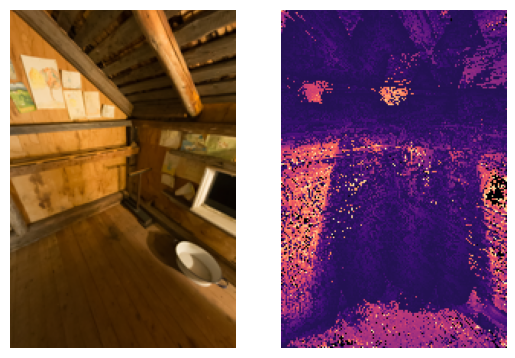

In [ ]:
fig, (a1, a2) = plt.subplots(1,2)
a1.imshow(anchor_image)
a1.axis("off")
a2.imshow(out_post, cmap="magma")
a2.axis("off")

In [ ]:
# Saving depth map
plt.figure(figsize=(6,12))
plt.axis("off")
plt.imshow(out_post, cmap="magma")
plt.savefig("../../report/depth_map_wta.png", bbox_inches='tight', transparent=True, pad_inches=0.0, dpi=300)
plt.close()

In [ ]:
# Saving anchor image
plt.figure(figsize=(6,12))
plt.axis("off")
plt.imshow(anchor_image)
plt.savefig("../../report/depth_map_wta_anchor.png", bbox_inches='tight', transparent=True, pad_inches=0.0, dpi=300)
plt.close()